# Do intracellular TE biomarkers work with extracellular samples?
```
5/23/23
Andrew E. Davidson
aedavids@ucsc.edu
```
ref:  
extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/bestSignatureGenesBaseMeanBugFixPOC.ipynb
extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/testIntraCellularBiomarkersOnExtracellularSamples.ipynb

<hr />
Preliminary evidence that intracellular TE biomarkers can be used on extracellular exomsomal data sets. I trained a logisitc regression classifier on our 32 PANC sample. Select best 20 gene loci. 

Best selection algo
1. select PAAD 1vs gene loci with abs(log2FoldChange) >= 2.0 and adjusted p-value < 0.001
2. sort baseMean in descending order
3. select top n=20<hr />
Preliminary evidence that intracellular biomarkers can be used on extracellular exomsomal data sets. I trained a logisitc regression classifier on our 32 PANC sample. Select best 20 gene loci. 

Best selection algo
1. select TE PAAD 1vs gene loci with abs(log2FoldChange) >= 2.0 and adjusted p-value < 0.001
2. sort baseMean in descending order
3. select top n=20

<span style="color:red">Model trained on all samples</span>  <span style="color:red">Model trained on all samples</span>  

**results**
LogisticRegression() Accuracy : 0.81

Accuracy is deceiving. Notice false positives > true positives for TE's

confusion matrix
```
    [[22  0]
     [ 6  4]]    
```


In [1]:
from IPython.display import display 
import joblib
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pathlib as pl
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# add our local python packages to path
import sys
sys.path.append('../python/src')
from confusion_matrix.cf_matrix import make_confusion_matrix
import intraExtraRNA.deseqUtilities as du
import intraExtraRNA.transposableElementUtilities as teu
import intraExtraRNA.utilities as ut

LOCAL_CACHE_DIR="/scratch/aedavids/tmp"
NOTEBOOK_NAME = "testIntraCellular-TE-BiomarkersOnExtracellularSamples"
imgOutPl = pl.Path("img/" + NOTEBOOK_NAME)
imgOutPl.mkdir(parents=True, exist_ok=True)

modelOutPL = pl.Path("models").joinpath(NOTEBOOK_NAME)
modelOutPL.mkdir(parents=True, exist_ok=True)

## Identify TE gene ids
1 vs. all results are HUGO gene name + a similar convension for TE's and repeats. 
we can use the txt.to.gene.csv file to find the TE's. The HUGO genes are the top of the file. These rows
start with ENST

In [2]:
# bestGenesList geneId HUGO format.
# countDF gene ids are in in ENSG format or loci . ex. ENSG00000227232.5 and (AAAAAC)n
file="/private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv"
tx2geneFilePath = pl.Path(file)
tx2GeneDF, geneCodeGeneGeneIdList, transposableElementGeneIdList = teu.loadTx2Genes(tx2geneFilePath)

In [3]:
print(tx2GeneDF.shape)
display(tx2GeneDF.head(n=3))
print()
tx2GeneDF.tail(n=3)

(5837318, 1)


,uberId
geneId,
DDX11L1,ENST00000456328.2|ENSG00000223972.5|OTTHUMG000...
DDX11L1,ENST00000450305.2|ENSG00000223972.5|OTTHUMG000...
WASH7P,ENST00000488147.1|ENSG00000227232.5|OTTHUMG000...


,uberId
geneId,
L1PA3,hg38_rmsk_L1PA3_range=chr22_KI270739v1_random:...
L1PA3,hg38_rmsk_L1PA3_range=chr22_KI270739v1_random:...
ALR/Alpha,hg38_rmsk_ALR/Alpha_range=chr22_KI270739v1_ran...


In [4]:
print(len(transposableElementGeneIdList))
print(transposableElementGeneIdList[0:3])
print(transposableElementGeneIdList[-3:])

15519
['(GGCCTG)n', '(CAACGCC)n', '(TACCTATA)n']
['(GAGGTGG)n', '(TGTTGTC)n', '(AAGACT)n']


## Select biomarker genes

In [5]:
# load our 1vsAll DESeq2 results
category = 'PAAD_vs_all.results'
resultsFile = '/private/groups/kimlab/GTEx_TCGA/1vsAll/' + category

resultsDF = du.loadDESEqResults(resultsFile, skiprows=7)
print(f'shape: {resultsDF.shape}')
resultsDF.head()

shape: (65406, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
name,,,,,,
CELA2B,1332.659848,13.266912,0.484407,27.387922,3.819727e-165,1.412612e-160
ENPP3,321.790901,-5.689927,0.222926,-25.523852,1.071664e-143,1.981613e-139
VILL,687.481732,3.114475,0.127290,24.467473,3.279913e-132,4.043259e-128
POU3F3,675.194100,-8.707841,0.364690,-23.877352,5.266121e-126,4.868792e-122
LRP2,1211.112568,-7.771070,0.330318,-23.525996,2.211008e-122,1.635350e-118


In [6]:
TEResultsDF = du.selectGenesOfInterest(resultsDF, transposableElementGeneIdList)
print(TEResultsDF.shape)

(7085, 6)


In [7]:
display(resultsDF.head())
print()
resultsDF.tail()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
name,,,,,,
CELA2B,1332.659848,13.266912,0.484407,27.387922,3.819727e-165,1.412612e-160
ENPP3,321.790901,-5.689927,0.222926,-25.523852,1.071664e-143,1.981613e-139
VILL,687.481732,3.114475,0.127290,24.467473,3.279913e-132,4.043259e-128
POU3F3,675.194100,-8.707841,0.364690,-23.877352,5.266121e-126,4.868792e-122
LRP2,1211.112568,-7.771070,0.330318,-23.525996,2.211008e-122,1.635350e-118


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
name,,,,,,
tRNA-Tyr-TAC,0.025061,0.046255,1.932849,0.023931,0.980908,NaN
tRNA-Tyr-TAT,0.005325,0.192511,4.260676,0.045183,0.963961,NaN
tRNA-Val-GTA,0.007068,0.152398,3.116016,0.048908,0.960993,NaN
tRNA-Val-GTG,0.041385,0.290227,1.165908,0.248928,0.803416,NaN
tRNA-Val-GTY,0.025348,-0.032494,1.697924,-0.019137,0.984732,NaN


In [8]:
print(f'TEResultsDF.shape : {TEResultsDF.shape}')
bestDESeq2DF = du.selectBest(TEResultsDF, topN=20) 
print(f'shape: {bestDESeq2DF.shape}')

print('\ndo not be confused by descriptive stats for lfc. we filter using abs')
print('min abs > lfcThreshold')

colOrderList = ['baseMean', 'padj',  'absLog2FoldChange', 'log2FoldChange' ]
bestDESeq2DF.loc[:, colOrderList].describe()

print()
bestDESeq2DF

TEResultsDF.shape : (7085, 6)
significantDF.shape : (587, 6)
shape: (18, 7)

do not be confused by descriptive stats for lfc. we filter using abs
min abs > lfcThreshold



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,absLog2FoldChange
name,,,,,,,
MER65-int,556.802099,2.620277,0.159134,16.465900,6.449572e-61,3.359409e-58,2.620277
MER65C,388.243641,-2.273490,0.161676,-14.062046,6.498001e-45,1.365393e-42,2.273490
LTR54B,248.402453,2.413262,0.110440,21.851371,7.543373e-106,2.789690e-102,2.413262
LTR81B,107.510997,-2.380125,0.172778,-13.775617,3.573173e-43,6.673892e-41,2.380125
MER65B,92.648220,-2.378561,0.211343,-11.254482,2.201159e-29,1.562443e-27,2.378561
(GGT)n,63.499961,2.455226,0.249545,9.838825,7.660054e-23,2.807573e-21,2.455226
HERV30-int,57.513456,-2.287672,0.170835,-13.391103,6.816047e-41,1.140593e-38,2.287672
(TTCTCG)n,26.734924,-2.315476,0.453745,-5.103038,3.342440e-07,1.632894e-06,2.315476
(TGAA)n,15.557119,-4.749464,0.391838,-12.120982,8.177310e-34,8.330944e-32,4.749464


In [9]:
#select row that match our best genes
bestTEGenesList = bestDESeq2DF.index.to_list()
print(' '.join(bestTEGenesList[0:5]))
print(' '.join(bestTEGenesList[5:10]))
print(' '.join(bestTEGenesList[10:15]))
print(' '.join(bestTEGenesList[15:]))

MER65-int MER65C LTR54B LTR81B MER65B
(GGT)n HERV30-int (TTCTCG)n (TGAA)n (TTCAT)n
(CCG)n (ACCAC)n (TACACA)n (GCC)n (GAGGC)n
(GCG)n (CGG)n (CTCCCT)n


## Implement logistic regression

In [10]:
rootDir   = '/private/groups/kimlab/aedavids_data'
countDataPath = rootDir + "/" + 'panc_normal_norm_counts_2023-05-18.csv'
metaDataPath  = rootDir + "/" +'panc_normal_scaled_metaData_2023-05-18.csv'

countDF = pd.read_csv(countDataPath, index_col='gene')
print(f'countDF.shape : {countDF.shape}')

metaDF = pd.read_csv(metaDataPath)
print(f'metaDF.shape : {metaDF.shape}')

countDF.shape : (76555, 32)
metaDF.shape : (32, 17)


In [11]:
countDF.head()

,panc.1.2.3,panc.2.2.7,panc.3.2.5,panc.4.3.9,panc.5.4.5,panc.8.2.5,panc.7.1.1,panc.9.1.1,panc.10.1.2,panc.6.1.1,...,n31,n32,n33,n34,n35,n41,n42,n43,n44,n45
gene,,,,,,,,,,,,,,,,,,,,,
(A)n,0.0,0.0,1.398199,2.782073,0.0,0.448711,1.496324,10.788154,0.74722,1.685168,...,160.867843,120.270349,174.764405,147.27735,204.488252,109.839352,104.30979,379.943132,445.9268,139.999428
(AAA)n,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000
(AAAAAAC)n,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000
(AAAAAAG)n,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000
(AAAAAAT)n,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000


In [12]:
# select best genes
bestCounTmptDF = countDF.loc[bestTEGenesList, :]
print(bestCounTmptDF.shape)

(18, 32)


In [13]:
conditionList = metaDF.loc[:, 'condition'].to_list()

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(conditionList)

# quick visual check
tmpDF = pd.DataFrame( {
    'cat':conditionList,
    'oneHot': y } )

display(tmpDF.groupby(by="cat").count())
display(tmpDF.head())
print()
tmpDF.tail()

,oneHot
cat,
normal,22
panc,10


,cat,oneHot
0,panc,1
1,panc,1
2,panc,1
3,panc,1
4,panc,1


,cat,oneHot
27,normal,0
28,normal,0
29,normal,0
30,normal,0
31,normal,0


In [14]:
XNP = bestCounTmptDF.values.transpose()
print(XNP.shape)

(32, 18)


In [15]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lrModel = LogisticRegression()
#             , penalty='l2' # regularization some penalities do not work with some solvers
# tol=0.0001
# lrModel.fit(XNP, y, C=1.0 
#             ,random_state=42           
#             ,solver='lbfgs' 
#             , max_iterint=100
#           )

scaler = StandardScaler().fit(XNP)
scalerFilePath = modelOutPL.joinpath("standardScaler.data")
joblib.dump(scaler, scalerFilePath)

XScaled = scaler.transform(XNP)


lrModel = lrModel.fit(XScaled, y)
modelFilePath = modelOutPL.joinpath("logisticRegresion.data")
joblib.dump(lrModel, modelFilePath)

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 11.8 ms


['models/testIntraCellular-TE-BiomarkersOnExtracellularSamples/logisticRegresion.data']

In [16]:
yHat = lrModel.predict(XScaled)
print('{} Accuracy : {:.2f}'.format(lrModel, lrModel.score(XScaled, y)))

LogisticRegression() Accuracy : 0.81


In [17]:
confusion_matrix = confusion_matrix(y, yHat)
print(confusion_matrix)

[[22  0]
 [ 6  4]]


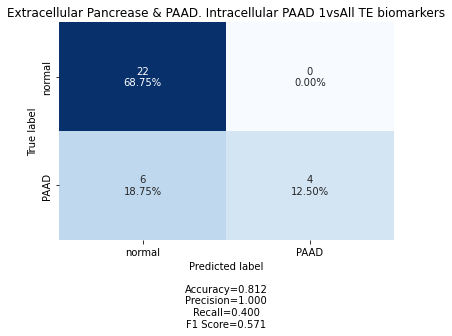

In [18]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
#categories = ['Zero', 'One']
categories = ["normal", "PAAD"]
title = "Extracellular Pancrease & PAAD. Intracellular PAAD 1vsAll TE biomarkers"
fig, panel = make_confusion_matrix(confusion_matrix, 
                      # group_names=labels,
                      categories=categories, 
                      cbar=False,
                      count=True,
                      cmap='Blues',
                      title=title
                     )

In [19]:
imgFilePL = imgOutPl.joinpath(NOTEBOOK_NAME + "-ConfusionMatrix.png")
print(imgFilePL)
fig.savefig(imgFilePL, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)

img/testIntraCellular-TE-BiomarkersOnExtracellularSamples/testIntraCellular-TE-BiomarkersOnExtracellularSamples-ConfusionMatrix.png
